In [1]:
# Feel free to import any other libraries and modules.
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

# Part One: Optimization Algorithms
## 1. Gradient Descent
The Gradient Descent (GD) algorithm finds the minimum of a given
function by taking small steps along the function's gradient:

>$\Theta \leftarrow \Theta_0$

>**while** stop condition not met **do**

>$~~~~$$\Theta \leftarrow \Theta - \alpha \nabla_\Theta f(\Theta)$

>**end while**

where $f$ is the function to minimize, $\nabla_\Theta f(\Theta)$
denotes $f$'s gradient at $\Theta$ and $\alpha$ is the learning rate.

**Task1:** Implement the GD algorithm as a function:

  \begin{equation}
      \Theta_{opt} = \text{GD}(f, \Theta_0, \alpha, \rho)
  \end{equation}
where $f$ is a function returning the cost and its gradient with respect to parameter vector $\Theta$, $\Theta_0$ is the initial value, and $\alpha$
is the learning rate. You can assume that $\alpha$. remains constant during the optimization. $\rho$ is stop condition. \\
Then, use the GD algorithm to find the optimum of the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) (Consider $a=1, b=100$).
 \\
Also, plot the values found by GD at subsequent iterations.

## 2. Newton's Method
Newton's method is an iterative optimization algorithm used to find the minimum of a function.
The basic update step in Newton's method is given by:

\begin{equation}
\Theta = \Theta - H^{-1} \cdot \nabla f(\Theta)
\end{equation}


Where  $ H $ is the Hessian matrix of the function at $ \Theta $, and $ H^{-1} $ is the inverse of the Hessian matrix, used to adjust the step size and direction more accurately than just using the gradient alone (as done in gradient descent).

#### Line Search
Sometimes, Newton's method may take too large of a step, which can lead to divergence. To prevent this, a simple **line search** is used. This reduces the step size $ \alpha $ if the function value doesn't improve after the step.

Steps:
1. Compute the gradient and Hessian matrix at the current point.
2. Calculate the step direction by multiplying the inverse of the Hessian with the gradient.
3. Update the point by subtracting the step from the current point.
4. If the function value doesn't improve, reduce the step size $ \alpha $.
5. Repeat until the gradient becomes sufficiently small (close to zero), indicating convergence.



**Task2:** Implement Newton's method and compare it with the gradient descent. You will also need to implement a line search alogithm, e.g. (https://en.wikipedia.org/wiki/Backtracking_line_search) and make sure that the Newton's direction is indeed one along which the function is minimized.


In [2]:
def rosenbrock(x):
    """Returns the value and gradient of Rosenbrock's function at x: 2d vector"""
    a = 1
    b = 100
    val = (a - x[0])**2 + b * (x[1] - x[0]**2)**2
    dv_dx0 = -2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0]**2)
    dv_dx1 = 2 * b * (x[1] - x[0]**2)
    grad = np.array([dv_dx0, dv_dx1])

    return val, grad

def rosenbrock_hessian(x):
    """Returns the value, gradient and hessian of Rosenbrock's function at x: 2d vector"""
    val, grad = rosenbrock(x)
    a = 1
    b = 100
    # Hessian matrix components
    d2v_dx0x0 = 2 - 4 * b * (x[1] - x[0]**2) + 8 * b * x[0]**2
    d2v_dx0x1 = -4 * b * x[0]
    d2v_dx1x0 = -4 * b * x[0]
    d2v_dx1x1 = 2 * b

    # Hessian matrix
    hessian = np.array([[d2v_dx0x0, d2v_dx0x1],
                [d2v_dx1x0, d2v_dx1x1]])

    return val, grad, hessian



def GD(f, theta0, alpha, stop_tolerance=1e-10, max_steps=1000000):
    """Runs gradient descent algorithm on f.

    Args:
        f: function that when evaluated on a Theta of same dtype and shape as Theta0
            returns a tuple (value, dv_dtheta) with dValuedTheta of the same shape
            as Theta
        theta0: starting point
        alpha: step length
        stop_tolerance: stop iterations when improvement is below this threshold
        max_steps: maximum number of steps
    Returns:
        tuple:
        - theta: optimum theta found by the algorithm
        - history: list of length num_steps containing tuples (theta, (val, dv_dtheta: np.array))

    """
    history = []

    theta = theta0

    step = 0
    while step < max_steps:
        val, grad = f(theta)
        theta_new = theta - alpha * grad
        history.append([theta, (val, grad)])

        # Check for convergence
        if np.linalg.norm(theta_new - theta) < stop_tolerance:
            break

        theta = theta_new
        step += 1

    return theta, history

Found optimum at [0.99999989 0.99999978] in 37027 steps (true minimum is at [1,1])


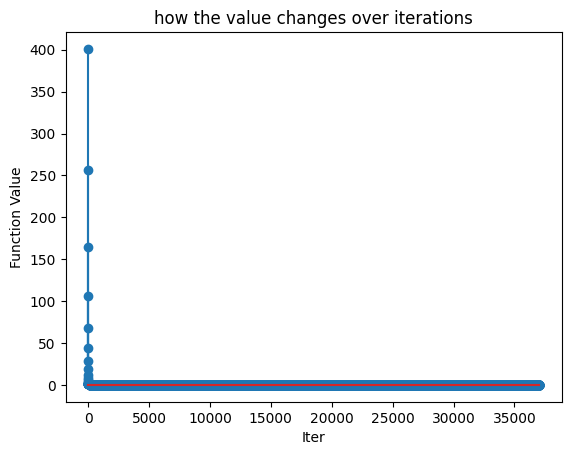

In [3]:
# Find the optimum of Rosenbrock function
X0 = [0., 2.]
Xopt, Xhist = GD(rosenbrock, X0, alpha=1e-3, stop_tolerance=1e-10, max_steps=1e6)

print("Found optimum at %s in %d steps (true minimum is at [1,1])" % (Xopt, len(Xhist)))

# Plot how the value changes over iterations
values = []
for theta, (val, _) in Xhist:
    values.append(val)

plt.stem(values)
plt.xlabel('Iter')
plt.ylabel('Function Value')
plt.title('how the value changes over iterations')
plt.show()

In [4]:
# Newton's Method
def Newton(f, theta0, alpha=1, stop_tolerance=1e-10, max_steps=1000000):
    """Performs Newton's optimization method with a simple line search.

    Args:
        f: function that when evaluated on a Theta of same dtype and shape as Theta0
            returns a tuple (value, gradient, hessian), where gradient and Hessian
            have the same shape as Theta.
        theta0: starting point.
        alpha: step length for backtracking line search (default is 1).
        stop_tolerance: stop iterations when the norm of the gradient is below this threshold.
        max_steps: maximum number of iterations.
    Returns:
        tuple:
        - theta: optimal Theta after convergence or maximum steps.
        - history: list of tuples (theta, value, gradient) containing the optimization path.
    """
    theta = theta0
    history = []

    for _ in range(max_steps):
        value, grad, hess = f(theta)
        history.append((theta, value, grad))

        # Check for convergence
        if np.linalg.norm(grad) < stop_tolerance:
            break

        # Line search (backtracking)
        t = alpha
        while f(theta - t * np.linalg.inv(hess) @ grad)[0] > value:
            t *= 0.5

        # Update step
        theta = theta - t * np.linalg.inv(hess) @ grad

    return theta, history

# Test Newton's method on the Rosenbrock function
X0 = [0., 2.]  # Initial guess
Xopt, Xhist = Newton(rosenbrock_hessian, X0)

print("Found optimum at %s (true minimum is at [1,1])" % Xopt)


Found optimum at [1. 1.] (true minimum is at [1,1])


**Comparing Newton and GD**: Newton is faster, but it does not have good global convergence. On the other hand, GD is slower, but it definitely converges.

# Part two: MLP for MNIST Classification
In this part, we are going to use `PyTorch`. If you want to become more familiar with it, check this resource: https://www.learnpytorch.io/

#### In this homework, you need to
- implement SGD optimizer (`./optimizer.py`)
- implement forward and backward for FCLayer (`layers.py`)
- implement forward and backward for SigmoidLayer (`layers.py`)
- implement forward and backward for ReLULayer (`layers.py`)
- implement forward and backward for DropoutLayer (`layers.py`)
- implement train and test process (`solver.py`)

In [22]:
from layers import FCLayer, SigmoidLayer, ReLULayer
from solver import train, test
from optimizer import SGD

In [15]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [31]:
# Load MNIST dataset

# Converts PIL image to tensor and scales to [0, 1] and flatten it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),  # Flatten the image to a 1D tensor
])

# Load MNIST dataset with the defined transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Labels are already in integer form, no need for one-hot encoding
y_train = [label for _, label in train_dataset]  # Keep labels as integers
y_test = [label for _, label in test_dataset]  # Keep labels as integers

# Convert the data into tensor datasets for training and testing
train_dataset = TensorDataset(torch.stack([img for img, _ in train_dataset]), torch.tensor(y_train))
test_dataset = TensorDataset(torch.stack([img for img, _ in test_dataset]), torch.tensor(y_test))

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:
# Set the number of epochs and learning rate
num_epoch = 20

# Use CrossEntropyLoss for classification tasks
criterion = nn.CrossEntropyLoss()

# Build MLP with FCLayer and SigmoidLayer you've implemented in layers.py
sigmoidMLP = nn.Sequential(
    FCLayer(784, 128),  # Input layer: 784 (28x28 images) to 128 neurons
    ReLULayer(),  # Add ReLU activation after the first layer
    FCLayer(128, 10)  # Output layer: 128 neurons to 10 classes (for MNIST)
)

# Initialize the optimizer you've implemented in optimizer.py
sgd = SGD(params=sigmoidMLP.parameters(), learning_rate=0.01)

# Train the model using the train function you've implemented in solver.py
sigmoidMLP = train(sigmoidMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.6420, Average training accuracy: 0.8405

Epoch [1] Average training loss: 0.3355, Average training accuracy: 0.9063

Epoch [2] Average training loss: 0.2881, Average training accuracy: 0.9185

Epoch [3] Average training loss: 0.2591, Average training accuracy: 0.9266

Epoch [4] Average training loss: 0.2373, Average training accuracy: 0.9333

Epoch [5] Average training loss: 0.2199, Average training accuracy: 0.9386

Epoch [6] Average training loss: 0.2046, Average training accuracy: 0.9425

Epoch [7] Average training loss: 0.1919, Average training accuracy: 0.9459

Epoch [8] Average training loss: 0.1806, Average training accuracy: 0.9490

Epoch [9] Average training loss: 0.1706, Average training accuracy: 0.9521

Epoch [10] Average training loss: 0.1615, Average training accuracy: 0.9552

Epoch [11] Average training loss: 0.1534, Average training accuracy: 0.9569

Epoch [12] Average training loss: 0.1462, Average training accuracy: 0.9591

Epoch [1

In [36]:
# Test your model using test function you've implemented in solver.py
test(sigmoidMLP, test_dataloader, device)

The test accuracy is 0.9657.



In [37]:
# Build MLP with FCLayer and ReLULayer
reluMLP = nn.Sequential(
    FCLayer(784, 128),
    ReLULayer(),
    FCLayer(128, 10)
)

# Initialize optimizer
sgd = SGD(reluMLP.parameters(), learning_rate=0.01)

# Train the model
reluMLP = train(reluMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.6409, Average training accuracy: 0.8378

Epoch [1] Average training loss: 0.3402, Average training accuracy: 0.9050

Epoch [2] Average training loss: 0.2917, Average training accuracy: 0.9187

Epoch [3] Average training loss: 0.2612, Average training accuracy: 0.9274

Epoch [4] Average training loss: 0.2381, Average training accuracy: 0.9335

Epoch [5] Average training loss: 0.2193, Average training accuracy: 0.9390

Epoch [6] Average training loss: 0.2037, Average training accuracy: 0.9436

Epoch [7] Average training loss: 0.1897, Average training accuracy: 0.9468

Epoch [8] Average training loss: 0.1780, Average training accuracy: 0.9504

Epoch [9] Average training loss: 0.1675, Average training accuracy: 0.9536

Epoch [10] Average training loss: 0.1583, Average training accuracy: 0.9562

Epoch [11] Average training loss: 0.1500, Average training accuracy: 0.9585

Epoch [12] Average training loss: 0.1427, Average training accuracy: 0.9604

Epoch [1

In [38]:
# Test the model
test(reluMLP, test_dataloader, device)

The test accuracy is 0.9670.



### Overfit the model
Try to overfit the reluMLP model. You can make the model as complex as you like, use subset of the data for training or any other approach you want.
Then add **DropoutLayer** to your model in order to reduce overfitting problem.

In [50]:
#TODO: overfit the reluMLP model

# Select a small subset of the data (e.g., only 1000 samples)
subset_train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
subset_train_dataloader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset, range(1000)), batch_size=32)

# Increase model complexity (more layers or neurons)
overfit_mlp = nn.Sequential(
    FCLayer(784, 512),   # Increase the number of neurons
    ReLULayer(),
    FCLayer(512, 256),   # Add another hidden layer
    ReLULayer(),
    FCLayer(256, 10)     # Output layer
)

# Initialize the optimizer (use a high learning rate to promote overfitting)
sgd_overfit = SGD(params=overfit_mlp.parameters(), learning_rate=0.1)

# Train the model for a large number of epochs to force overfitting
overfit_mlp = train(overfit_mlp, criterion, sgd_overfit, subset_train_dataloader, num_epoch=100, device=device)



Epoch [0] Average training loss: 1.3637, Average training accuracy: 0.6260

Epoch [1] Average training loss: 0.6012, Average training accuracy: 0.8301

Epoch [2] Average training loss: 0.3990, Average training accuracy: 0.8877

Epoch [3] Average training loss: 0.2909, Average training accuracy: 0.9189

Epoch [4] Average training loss: 0.2245, Average training accuracy: 0.9424

Epoch [5] Average training loss: 0.1768, Average training accuracy: 0.9541

Epoch [6] Average training loss: 0.1402, Average training accuracy: 0.9727

Epoch [7] Average training loss: 0.1117, Average training accuracy: 0.9795

Epoch [8] Average training loss: 0.0891, Average training accuracy: 0.9873

Epoch [9] Average training loss: 0.0712, Average training accuracy: 0.9941

Epoch [10] Average training loss: 0.0571, Average training accuracy: 0.9971

Epoch [11] Average training loss: 0.0462, Average training accuracy: 0.9990

Epoch [12] Average training loss: 0.0381, Average training accuracy: 1.0000

Epoch [1

In [51]:
test(overfit_mlp, test_dataloader, device)

The test accuracy is 0.8869.



In [52]:
from layers import DropoutLayer

#TODO: add DropoutLayer to your model
dropout_mlp = nn.Sequential(
    FCLayer(784, 512),
    ReLULayer(),
    DropoutLayer(0.5),  # Add dropout with a 50% probability
    FCLayer(512, 256),
    ReLULayer(),
    DropoutLayer(0.5),  # Add another dropout layer
    FCLayer(256, 10)
)

# Initialize the optimizer
sgd_dropout = SGD(params=dropout_mlp.parameters(), learning_rate=0.01)

# Train the model with dropout to reduce overfitting
dropout_mlp = train(dropout_mlp, criterion, sgd_dropout, subset_train_dataloader, num_epoch=100, device=device)



Epoch [0] Average training loss: 2.3628, Average training accuracy: 0.1104

Epoch [1] Average training loss: 2.1116, Average training accuracy: 0.2334

Epoch [2] Average training loss: 1.9673, Average training accuracy: 0.3398

Epoch [3] Average training loss: 1.8185, Average training accuracy: 0.4375

Epoch [4] Average training loss: 1.6875, Average training accuracy: 0.4990

Epoch [5] Average training loss: 1.4991, Average training accuracy: 0.5645

Epoch [6] Average training loss: 1.4223, Average training accuracy: 0.5840

Epoch [7] Average training loss: 1.3184, Average training accuracy: 0.6094

Epoch [8] Average training loss: 1.2089, Average training accuracy: 0.6543

Epoch [9] Average training loss: 1.1163, Average training accuracy: 0.6758

Epoch [10] Average training loss: 1.0752, Average training accuracy: 0.6846

Epoch [11] Average training loss: 0.9734, Average training accuracy: 0.7207

Epoch [12] Average training loss: 0.9737, Average training accuracy: 0.7148

Epoch [1

In [53]:
test(dropout_mlp, test_dataloader, device)

The test accuracy is 0.8878.

